# Stock Recommendation Based on Sentiment Analysis / Natural Language Processing

www.finviz.com is a website who hosts stock charts and their news articles. It has great data visualization about the stock performance. 

In this exercise, the focus is to use <strong>Sentiment Analysis</strong> on financial news headlines from <a href="https://finviz.com">www.finviz.com</a> by using natural language technique. By detecting the emotion behind the headlines, we will predict whether the market *feels* good or bad about a specific stock. 

This is a datacamp project. Currently, I am saving the .html files in the local drive. In the future, the plan is to get into ethically web-scraping to allow automation. 

Disclaimer: There are risks in the stock market. The content in this notebook is not to be taken as financial advice. 



In [47]:
# library
from bs4 import BeautifulSoup
import os
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Read the Files and Review Contents

In [48]:
# The .html files are saved in the 'datasets' folder. 
# In each html file, the infomration that we want is in the section 
# where the id = 'news-table'
html_tbls = dict()
for file in os.listdir('datasets'): 
    filepath = f'datasets/{file}'
#     html = BeautifulSoup(open(filepath),features="xml")
    html = BeautifulSoup(open(f'datasets/{file}','r'))
    html_tbl=html.find(id='news-table') 
    html_tbls[file]=html_tbl

In [49]:
files = os.listdir('datasets')
print('These files are in the datasets folder: ', files, '\n')
tsla = html_tbls['tsla_22sep.html'] #randomly pick one of them to peak
tsla_tr = tsla.findAll('tr')
print('Picked the stock "TSLA". Sneak Peak of the first 3 lines \n')
for i, table_row in enumerate(tsla_tr): 
    if i<3: #just peak the first 3 
        link_a = table_row.a.get_text() #Read the text contents of the <a> tag
        link_td = table_row.td.get_text()#Read the contents of the <td> tag.
        print('Sample link_a', i, link_a)
        print('Sample link_td', i, link_td)

These files are in the datasets folder:  ['ba_03jun.html', 'fb_05ene.html', 'fb_22sep.html', 'gpro_06jun.html', 'nvda_06jun.html', 'tsla_05ene.html', 'tsla_22sep.html', 'tsla_26nov.html'] 

Picked the stock "TSLA". Sneak Peak of the first 3 lines 

Sample link_a 0 Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sample link_td 0 Sep-21-18 09:56PM  
Sample link_a 1 Broadcoms Stock Looks Like a Winner
Sample link_td 1 09:30PM  
Sample link_a 2 SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
Sample link_td 2 05:30PM  


#### Observation
As seen above, the information inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags. 

link_td* to store the <code>&lt;td&gt;</code> which has the date/time; 

link_a* to store the <code>&lt;a&gt;</code> which has the content. 

Next task: parse the data for <strong>all</strong> tables and convert to a data structure.


In [50]:
parsed_news = []
for file, news_table in html_tbls.items(): 
    for x in news_table.findAll('tr'): 
        headline = x.a.get_text()
        date_scrape = x.td.get_text().split() 
        if len(date_scrape) ==1: 
            date = date_scrape[0]
        else: 
            date = date_scrape[0]
            time = date_scrape[1]
        symbol = file.split('_')[0]
        parsed_news.append([symbol, date, time, headline])

print('Peak of the first item:')
print(parsed_news[0])

Peak of the first item:
['ba', 'Jun-03-20', '04:38PM', 'Stock Market Today: Dow Shoots Past 26K in Third Straight Gain']


#### Add financial keywords to the (nltk) analysis

<p>Sentiment analysis is very sensitive to context. As an example, saying <em>"This is so addictive!"</em> often means something positive if the context is a video game you are enjoying with your friends, but it very often means something negative when we are talking about opioids. The reason we chose headlines is so we can try to extract sentiment from financial journalists, who like most professionals, have their own lingo. Let's now make NLTK think like a financial journalist by adding some new words and sentiment values to our lexicon.</p>

In [51]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# New words and values
new_words = {
    'crushes': 10,'crushed': 10,
    'beats': 5,'beat': 5,
    'misses': -5,'missed': -5,
    'trouble': -10,'troubled'
    'falls': -100,'fell': -100    
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)

In [52]:
base_df = pd.DataFrame(data=parsed_news, 
                       columns = ['sym', 'date', 'time', 'headline'])
scores = [vader.polarity_scores(i) for i in base_df['headline'].values]
scores_df = pd.DataFrame(scores)
base_df = pd.concat([base_df, scores_df], axis=1)
base_df['date'] = pd.to_datetime(base_df['date']).dt.date
base_df['time'] = pd.to_datetime(base_df['time']).dt.time
# print(base_df['headline'].count())

# Remove Duplicates Headlines
base_df = base_df.drop_duplicates(subset = ['sym', 'headline'])


Now I have created a nice dataframe to show the data. 

In [57]:
print('The Base Table Below: ')
display(base_df.head(2))
# print(base_df['headline'].count())

The Base Table Below: 


,sym,date,time,headline,compound,neg,neu,pos
0,ba,2020-06-03,16:38:00,Stock Market Today: Dow Shoots Past 26K in Thi...,0.6486,0.000,0.629,0.371
1,ba,2020-06-04,16:38:00,Stock market news live updates: Stocks rise fo...,-0.5106,0.225,0.693,0.082


#### Look at a Single Stock's Single Day Score over Time of Day
In this exercise, Let's pick the stock BA (Boeing) and analyze its headline news posted on Jun 4, 2020 only. 

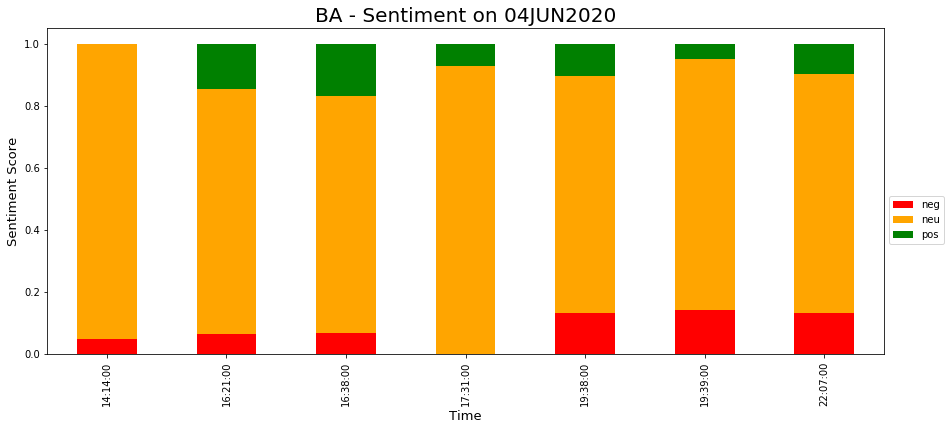

In [54]:
# Only want to see BA on Jun 4, 2020
mydate = datetime.date(year=2020,month=6,day=4)
mystock = 'ba'
sym_date_time = base_df.groupby(['sym', 'date', 'time'], as_index = False).mean()

mystock_mydate = sym_date_time[sym_date_time['sym']==mystock]
mystock_mydate = mystock_mydate[mystock_mydate['date'] == mydate]
mystock_mydate = mystock_mydate.drop(columns = ['compound'])
mystock_mydate.set_index('time')

mystock_mydate.plot.bar(x='time', stacked = True, figsize=(15,6),
#                 title = "BA Neg, Neu,Pos Sentiment on 04JUN2020", 
                color=['red','orange','green']).legend(bbox_to_anchor=(1,0.5))
plt.ylabel('Sentiment Score', fontsize = 13)
plt.xlabel('Time', fontsize = 13)
plt.title("BA - Sentiment on 04JUN2020",fontsize = 20)
plt.show()
                                               

#### Look at Various Stocks' Recent Compound Ratings Over Time

I am really interested in reviewing recent Compound scores of all these stocks in my profile over the past 3 weeks. 

In [55]:
sym_date = base_df.groupby(['sym', 'date'], as_index = False).mean()
startdate = datetime.date.today()- datetime.timedelta(days=21)

sym_date = sym_date[sym_date['date']>=startdate]
sym_date = sym_date.drop(columns = ['neg', 'neu', 'pos'])
sym_date.set_index('date')
print('Data Frame Sneak Peak')
display(sym_date.head(3))

Data Frame Sneak Peak


,sym,date,compound
0,ba,2020-05-28,0.0000
1,ba,2020-05-29,0.0000
2,ba,2020-05-30,0.4939


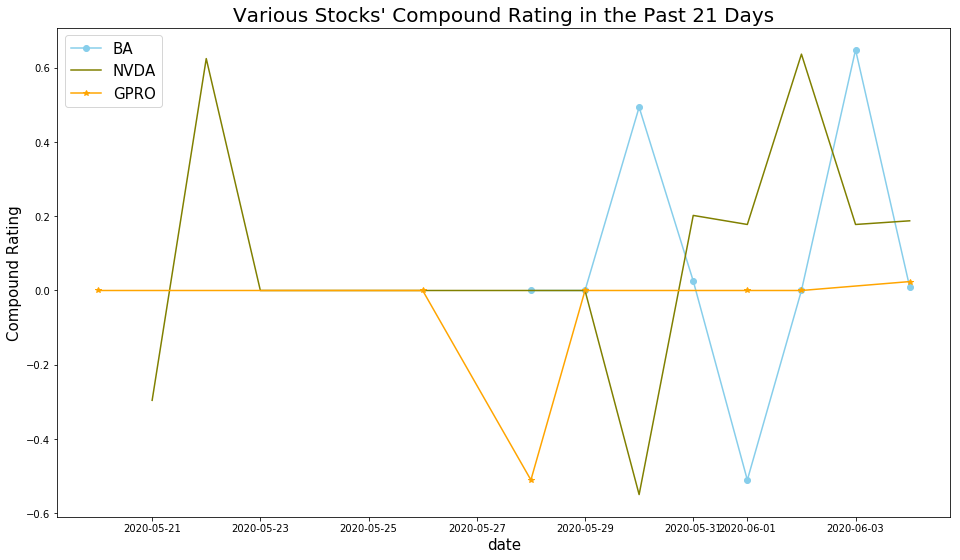

In [56]:
plt.figure(figsize=(16, 9))
plt.plot( 'date', 'compound', data=sym_date[sym_date['sym']=='ba'], marker='o', 
         color='skyblue', label='BA')
plt.plot( 'date', 'compound', data=sym_date[sym_date['sym']=='nvda'], marker='', 
         color='olive', label='NVDA')
plt.plot( 'date', 'compound', data=sym_date[sym_date['sym']=='gpro'], marker='*', 
         color='orange', label="GPRO") #linewidth=2, linestyle='dashed'
plt.title("Various Stocks' Compound Rating in the Past 21 Days",
         fontsize=20)
plt.xlabel('date', fontsize=15)
plt.ylabel('Compound Rating', fontsize=15)
plt.legend(fontsize=15)
plt.show()

#### Observation: 
NVDA has recently become a hot item. BA stayed neutual for a while, and recently has its up-and-downs. GPRO is quite a loser, sadly. 